In [1]:
import numpy as np
import pandas as pd

# PyTorch stuff we'll need
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

## Learning Rate Scheduler

In [2]:
# model and optimizer
model = nn.Sequential(nn.Linear(2, 5),
                      nn.ReLU(),
                      nn.Linear(5, 1))
optimizer = optim.Adam(model.parameters(), lr = 0.001)

We can group the parameters of our model into different groups (will be used for transfer learning later)
- here we only have one group
- note the learning rate

In [3]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[-0.3843,  0.0384],
           [ 0.4522,  0.1577],
           [ 0.3327,  0.2122],
           [-0.2092, -0.6796],
           [ 0.1233, -0.4563]], requires_grad=True),
   Parameter containing:
   tensor([ 0.4535, -0.6779,  0.7033,  0.5318, -0.0382], requires_grad=True),
   Parameter containing:
   tensor([[-0.1363,  0.1813,  0.1070, -0.1269, -0.0951]], requires_grad=True),
   Parameter containing:
   tensor([-0.1145], requires_grad=True)],
  'lr': 0.001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False}]

The learning rate scheduler lets us adjust the learning rate according to different schemes
- For example the following is [Cosine Annealing](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR) set for 100 iterations

In [4]:
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)

In [5]:
# why do you think we are getting an error here?
print(optimizer.param_groups[0]['lr'])
lr_scheduler.step()
print(optimizer.param_groups[0]['lr'])

0.001
0.0009997532801828658


/Users/mruddy/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [6]:
for i in range (10):
    lr_scheduler.step()
    print(optimizer.param_groups[0]['lr'])

0.0009990133642141358
0.00099778098230154
0.000996057350657239
0.0009938441702975688
0.0009911436253643444
0.0009879583809693736
0.0009842915805643154
0.0009801468428384714
0.0009755282581475767
0.0009704403844771127


Try implementing and plotting the learning rate for a [One Cycle](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR) learning rate

## Dropout

The layer ```nn.Dropout(p)``` randomly zeros out elements on the input tensor with probability ```p```. The resulting tensor is then scaling by $\frac{1}{1-p}$.
- Keeps output same scale as during test time (no dropout)
- Think about it as adding noise with mean 0

In [7]:
drop = nn.Dropout(p=.2)
x = torch.ones((100,100))
print(x)
y = drop(x)
y

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


tensor([[1.2500, 0.0000, 1.2500,  ..., 1.2500, 1.2500, 1.2500],
        [1.2500, 1.2500, 1.2500,  ..., 1.2500, 1.2500, 1.2500],
        [0.0000, 1.2500, 1.2500,  ..., 1.2500, 0.0000, 1.2500],
        ...,
        [1.2500, 1.2500, 1.2500,  ..., 1.2500, 0.0000, 0.0000],
        [1.2500, 1.2500, 0.0000,  ..., 1.2500, 1.2500, 1.2500],
        [1.2500, 1.2500, 1.2500,  ..., 1.2500, 1.2500, 0.0000]])

In [8]:
# model with Dropout
class TwoLayerNN_drop(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN_drop, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=.25)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        
        # Add some dropout after first layer
        x = self.dropout(x)
        
        x = self.linear2(x)
        return torch.squeeze(x)

## Weight Decay
- Let's use [Stochastic Gradient Descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) with weight decay

In [10]:
# blowing up weight decay so you can see it in action

model = nn.Sequential(nn.Linear(2, 5),
                      nn.ReLU(),
                      nn.Linear(5, 1))
optimizer = optim.SGD(model.parameters(), lr = 0.001, weight_decay = 1000.0)

In [11]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.0916, -0.3457],
        [-0.5323,  0.4186],
        [ 0.6023, -0.2609],
        [ 0.7036, -0.5056],
        [-0.0539, -0.6889]], requires_grad=True)
Parameter containing:
tensor([ 0.6933,  0.4068, -0.6345, -0.5084, -0.5809], requires_grad=True)
Parameter containing:
tensor([[ 0.2265, -0.0958,  0.3567, -0.3540,  0.2141]], requires_grad=True)
Parameter containing:
tensor([-0.1624], requires_grad=True)


In [12]:
model.train()
y = model(torch.ones(10, 2))

# train w.r.t a loss function that wants to maximize output
(1/sum(y)).backward()
optimizer.step()

In [13]:
# weights have decreased
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 2.7365e-03,  2.7366e-03],
        [-1.1578e-03, -1.1579e-03],
        [ 0.0000e+00,  0.0000e+00],
        [-5.9605e-08,  5.9605e-08],
        [ 0.0000e+00,  0.0000e+00]], requires_grad=True)
Parameter containing:
tensor([ 2.7365e-03, -1.1578e-03,  0.0000e+00,  0.0000e+00,  5.9605e-08],
       requires_grad=True)
Parameter containing:
tensor([[ 5.3083e-03,  3.5427e-03,  0.0000e+00,  2.9802e-08, -1.4901e-08]],
       requires_grad=True)
Parameter containing:
tensor([0.0121], requires_grad=True)


## Batch Normalization

In [14]:
# model with batch normalization
class TwoLayerNN_BN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN_BN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
        # we input the number of features to be normalizing across a batch
        self.bn = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x):
        x = self.linear1(x)
        
        # add batch normalization before activation
        x = self.bn(x)
        x = self.relu(x)
        
        x = self.linear2(x)
        # no batch norm for final output!
        
        return torch.squeeze(x)

In [15]:
model = TwoLayerNN_BN(2, 5, 1)
bn_layer = model.bn

# note that batch normalization intializes with pure mini-batch noramlization
# will change during training
for param in bn_layer.parameters():
    print(param)

Parameter containing:
tensor([1., 1., 1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)


## Early Stopping
- ideas
 * stop training after validation loss does not improve after so many epochs
 * save model parameters after each epoch if they are a new minimum validation loss

In [16]:
import seaborn as sns
mpg = sns.load_dataset('mpg')
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [17]:
class MPGDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = torch.tensor([row['displacement'],
                          row['weight']]).float()
        
        y = torch.tensor(row['mpg']).float()
        
        return x, y

# train/val split
mpg_train = mpg[100:].reset_index(drop=True)
mpg_val = mpg[:100].reset_index(drop=True)
mpg_train_ds = MPGDataset(mpg_train)
mpg_val_ds = MPGDataset(mpg_val)

# load into dataloader
mpg_train_dl = DataLoader(mpg_train_ds, batch_size=50, shuffle=True)
mpg_val_dl = DataLoader(mpg_val_ds, batch_size=100, shuffle=False)

In [18]:
# vanilla two-layer
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)     
        x = self.linear2(x)
        return torch.squeeze(x)

In [19]:
# large network to induce overfitting
model = TwoLayerNN(2, 10, 1)
lossFun = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [20]:
from tqdm.notebook import tqdm

# collect losses
avg_train = []
avg_val = []

for epoch in tqdm(range(500)):
    train_losses = []
    for x, y in mpg_train_dl:
        
        model.train()
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
    
    avg_train.append(sum(train_losses) / len(train_losses))
    
    for x, y in mpg_val_dl:
        model.eval()
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        
        avg_val.append(loss.item())

  0%|          | 0/500 [00:00<?, ?it/s]

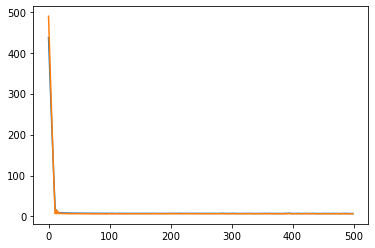

In [21]:
import matplotlib.pyplot as plt

# plot losses
plt.plot(avg_train)
plt.plot(avg_val)
plt.show()

What about with batch normalization?

  0%|          | 0/500 [00:00<?, ?it/s]

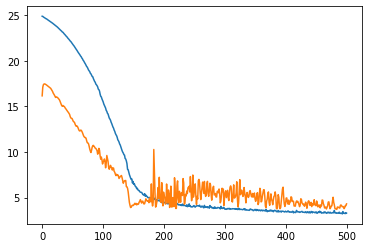

In [22]:
model = TwoLayerNN_BN(2, 10, 1)
lossFun = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# collect losses
avg_train = []
avg_val = []

for epoch in tqdm(range(500)):
    train_losses = []
    for x, y in mpg_train_dl:
        
        model.train()
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
    
    avg_train.append(sum(train_losses) / len(train_losses))
    
    for x, y in mpg_val_dl:
        model.eval()
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        
        avg_val.append(loss.item())
        
plt.plot(avg_train)
plt.plot(avg_val)
plt.show()

## Categorical Embeddings
- let's include the make of the car in our model

In [23]:
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [24]:
makes = []
for idx in range(len(mpg)):
    row = mpg.iloc[idx]
    makes.append(row['name'].split(' ')[0])
mpg['make'] = makes
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,make
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu,chevrolet
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320,buick
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite,plymouth
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst,amc
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino,ford


In [25]:
# create an index for possible values of make
# sort of like a one-hot-encoding here
make_dict = {make: i for i, make in enumerate(set(makes))}
make_dict

{'hi': 0,
 'maxda': 1,
 'nissan': 2,
 'opel': 3,
 'volvo': 4,
 'chevrolet': 5,
 'dodge': 6,
 'chevroelt': 7,
 'vw': 8,
 'mazda': 9,
 'oldsmobile': 10,
 'mercedes-benz': 11,
 'vokswagen': 12,
 'cadillac': 13,
 'saab': 14,
 'chevy': 15,
 'toyouta': 16,
 'volkswagen': 17,
 'plymouth': 18,
 'mercedes': 19,
 'capri': 20,
 'buick': 21,
 'honda': 22,
 'triumph': 23,
 'ford': 24,
 'fiat': 25,
 'renault': 26,
 'toyota': 27,
 'bmw': 28,
 'mercury': 29,
 'chrysler': 30,
 'amc': 31,
 'subaru': 32,
 'audi': 33,
 'datsun': 34,
 'pontiac': 35,
 'peugeot': 36}

In [26]:
class MPGDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        make_idx = make_dict[row['make']]
        
        x1 = torch.tensor([row['displacement'],
                          row['weight']]).float()
        
        x2 = torch.tensor(make_idx)
        
        y = torch.tensor(row['mpg']).float()
        
        return x1, x2, y
    
mpg_ds = MPGDataset(mpg)

# note the second tensor
next(iter(mpg_ds))

(tensor([ 307., 3504.]), tensor(5), tensor(18.))

In [27]:
# let's add an embedding layer
class TwoLayerNN_Emb(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN_Emb, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
        # first argument is number of values, next is size of embedding
        self.emb = nn.Embedding(len(make_dict), 2)
        
        # let's keep in batch normalization
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x1, x2):
        
        x2 = self.emb(x2)
        
        # concatenate the vectors along dim=1, skipping batch dim
        x = torch.cat((x1, x2), dim=1)
        
        x = self.linear1(x)
        x = self.bn(x)
        x = self.relu(x)
        
        x = self.linear2(x)
        
        return torch.squeeze(x)

In [29]:
mpg_dl = DataLoader(mpg_ds, batch_size=50, shuffle=True)

# what is the correct dimension here?
model = TwoLayerNN_Emb(?, 5, 1)
x1, x2, y = next(iter(mpg_dl))
model(x1, x2)

tensor([ 0.2747,  0.0255,  0.0156, -0.0200, -0.0629,  0.2738,  0.3669,  0.1282,
        -0.2217,  0.0352,  0.2713,  0.3461,  0.2559,  0.1992, -0.1745,  0.1129,
        -0.4905,  0.1851,  0.1871,  0.0125,  0.1986,  0.0280,  0.2584,  0.2194,
         0.1096,  0.3438,  0.1726,  0.1632,  0.3431,  0.2032,  0.2520, -0.3816,
         0.2649,  0.2775,  0.2579,  0.2208,  0.2265,  0.3569,  0.2672,  0.1927,
         0.0733,  0.1992,  0.0933,  0.1273, -0.2634,  0.0473, -0.0079, -0.0166,
         0.0304,  0.3636], grad_fn=<SqueezeBackward0>)

Let's train it the same way we did above

In [30]:
# train/val split
mpg_train = mpg[100:].reset_index(drop=True)
mpg_val = mpg[:100].reset_index(drop=True)
mpg_train_ds = MPGDataset(mpg_train)
mpg_val_ds = MPGDataset(mpg_val)

# load into dataloader
mpg_train_dl = DataLoader(mpg_train_ds, batch_size=50, shuffle=True)
mpg_val_dl = DataLoader(mpg_val_ds, batch_size=100, shuffle=False)

In [31]:
lossFun = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# collect losses
avg_train = []
avg_val = []

for epoch in tqdm(range(500)):
    train_losses = []
    for x1, x2, y in mpg_train_dl:
        
        model.train()
        
        y_pred = model(x1, x2)
        loss = lossFun(y_pred, y)
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
    
    avg_train.append(sum(train_losses) / len(train_losses))
    
    for x1, x2, y in mpg_val_dl:
        model.eval()
        
        y_pred = model(x1, x2)
        loss = lossFun(y_pred, y)
        
        avg_val.append(loss.item())

  0%|          | 0/500 [00:00<?, ?it/s]

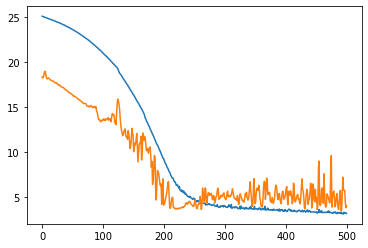

In [32]:
plt.plot(avg_train)
plt.plot(avg_val)
plt.show()

In [33]:
# let's look at the embedding matrix
for param in model.emb.parameters():
    print(param)

Parameter containing:
tensor([[ 1.2484e+00, -1.9823e+00],
        [ 1.0901e+00, -1.0681e+00],
        [-2.2786e+00, -3.1906e-01],
        [ 3.5918e+00, -3.1146e-01],
        [ 1.6091e+00,  2.0444e+00],
        [ 7.6363e-02,  1.3042e+00],
        [-7.8962e-01, -7.5728e-01],
        [ 2.2748e+00, -1.3825e+00],
        [-4.2404e-01, -1.1995e+00],
        [ 1.9134e+00, -9.7031e-01],
        [-2.4271e+00,  1.6282e+00],
        [ 2.0617e+00,  6.5937e-02],
        [ 9.0568e-01, -1.0628e+00],
        [ 3.0318e-01,  5.3386e-01],
        [ 9.7642e-01,  1.6910e+00],
        [-1.7186e+00,  1.6370e+00],
        [ 1.9963e-01,  1.1020e+00],
        [ 2.5825e+00, -2.2256e+00],
        [-3.6761e-01, -6.7609e-01],
        [-1.1743e+00, -6.3634e-01],
        [-1.0682e+00,  5.4431e-02],
        [-2.0933e+00,  2.9280e+00],
        [ 1.1894e+00, -4.8345e-01],
        [-2.9840e+00, -2.0543e-01],
        [-2.4898e-01,  2.0669e+00],
        [ 3.1518e+00, -7.4659e-01],
        [-3.6396e-02,  1.9744e-02],
      

In [ ]:
# compare embeddings for vw and volkswagon
for param in model.emb.parameters():
    print(param[?], param[?])